In [1]:
from collections import defaultdict
from copy import deepcopy
import re
from typing import Callable, List, Tuple

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from datetime import datetime
from sklearn.utils import shuffle

In [2]:
dataset = load_dataset("imdb")

Reusing dataset imdb (/home/miolith/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# We do not need the "unsupervised" split.
dataset.pop("unsupervised")

Dataset({
    features: ['text', 'label'],
    num_rows: 50000
})

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [5]:
dataset["train"][:2]

{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far b

### Pretreatment (1 point)

In [6]:
import string
import re

def pretreatment(text: str) -> str:
    """Clean IMDB text entries.
    Args:
        text: an input string.
    Returns:
        The cleaned text.
    """
    t = text.lower()
    t = re.sub('[{}]'.format(string.punctuation), ' ', t)
    
    return t

In [7]:
# This applies the pretreatment function to all
clean_dataset = dataset.map(lambda x: {"text": pretreatment(x["text"]), "label": x["label"]})

Loading cached processed dataset at /home/miolith/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-c4d8a8a4f4c36dbb.arrow
Loading cached processed dataset at /home/miolith/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-de2f4960df506b30.arrow


In [8]:
clean_dataset["train"]["text"][:3]

['i rented i am curious yellow from my video store because of all the controversy that surrounded it when it was first released in 1967  i also heard that at first it was seized by u s  customs if it ever tried to enter this country  therefore being a fan of films considered  controversial  i really had to see this for myself  br    br   the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life  in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states  in between asking politicians and ordinary denizens of stockholm about their opinions on politics  she has sex with her drama teacher  classmates  and married men  br    br   what kills me about i am curious yellow is that 40 years ago  this was considered pornographic  really  the sex and nudity scenes are few and far between  e

In [9]:
clean_dataset["train"]["label"][12490:12510]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

### Train/validation split (1 point)

In [68]:
clean_dataset_split = clean_dataset["train"].train_test_split(train_size=0.8, seed=42, stratify_by_column="label")

clean_dataset_split["validation"] = clean_dataset_split.pop("test")
clean_dataset_split["test"] = clean_dataset["test"]

In [69]:
clean_dataset_split

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

### Categorical encoding of the vocabulary (2 points)

In [13]:
UNK_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"


class Vocabulary:
    """Vocabulary manager on a collection.
    """
    def __init__(self) -> None:
        """No parameters to provide.
        """
        # Index to word mapping.
        self.index2word = [PAD_TOKEN, UNK_TOKEN]
        # Word to index mapping.
        self.word2index = {value: key for key, value in enumerate(self.index2word)}
        # Word counter.
        self.word2count = defaultdict(int)

    def add_word(self, word: str) -> None:
        """Increments the count of a word to the vocabulary.
        Args:
            word: the word.
        """
        self.word2count[word] += 1
        if not word in self.word2index:
            self.word2index[word] = len(self.index2word)
            self.index2word.append(word)

    def add_text(self, text: str, separator: str =" ") -> None:
        """Add the words given in a text to our vocabulary.
        Args:
            text: a sequence of words separated by a given separator.
            separator: the separator used to split our text (default is " ").
        """
        for word in text.split(separator):
            self.add_word(word)

    def get_index(self, word: str) -> int:
        """Returns the index of a given word in our vocabulary.
        If the word is not in the vocabulary, returns the index for UNK_TOKEN.
        Args:
            word: a string.
        Returns:
            The corresponding index or the index for UNK_TOKEN.
        """
        return (
            self.word2index[word]
            if word in self.word2index
            else self.word2index[UNK_TOKEN]
        )

    def get_word(self, index: int) -> str:
        """Returns the word at a given index in our vocabulary.
        Args:
            index: the word position in our vocabulary.
        Returns:
            The word corresponding to the given index.
        """
        return self.index2word[index]

    def get_word_count(self, word: str) -> int:
        """Returns the number of occurences for a given word.
        Raise a 
        Args:
            The word.
        Returns:
            Its number of measured occurences.
        """
        return self.word2count[word]

    def get_vocabulary(self) -> List[str]:
        """Returns a copy of the whole vocabulary list.
        Returns:
            A list of words.
        """
        return deepcopy(self.index2word)

    def __len__(self) -> int:
        """len() function.
        Returns:
            The number of words in the vocabulary.
        """
        return len(self.index2word)

    def trim_vocabulary(self, min_occurences: int = 5) -> None:
        """Trim the vocabulary based on the number of occurrences of each words.
        Note that whole counts of deleted words are added to the UNK_TOKEN counts.
        Args:
            min_occurences: the minimum number of occurences for a word to be kept.
        """
        to_delete = {
            word for word, count in self.word2count.items() if count < min_occurences
        }
        new_word2count = defaultdict(int)
        for word, count in self.word2count.items():
            if word not in to_delete:
                new_word2count[word] = count
            else:
                new_word2count[UNK_TOKEN] += count
        new_index2word = [word for word in self.index2word if word not in to_delete]
        new_word2index = {word: index for index, word in enumerate(new_index2word)}

        self.word2count = new_word2count
        self.index2word = new_index2word
        self.word2index = new_word2index

### (1 point) Get the vocabulary on both the training and validation set using the Vocabulary class. Trim it down as you see fit (around 20K words in the vocabulary is a good value).

In [14]:
vocabulary = Vocabulary()

for text in clean_dataset["train"]["text"]:
    vocabulary.add_text(text)

c = 3
while len(vocabulary.word2count) > 21000:
    vocabulary.trim_vocabulary(c)
    c += 1

print("Il y a", len(vocabulary.word2count), "mots de vocabulaire.")

Il y a 20145 mots de vocabulaire.


### (1 point) Fill the encoding and decoding functions. The encoding function takes a text as input and returns a list IDs corresponding to the index of each word in the vocabulary. The decoding function reverse the process, turning a list of IDs into a text. Make sure the encoding function returns a numpy array.

In [15]:
def encode_text(text: str) -> np.ndarray:
    rep = []
    for word in text.split(' '):
        rep.append(vocabulary.word2index.get(word, vocabulary.word2index[UNK_TOKEN]))
        
    return np.array(rep)


def decode_text(encoded_text: np.ndarray) -> str:
    
    return " ".join(map((lambda x : vocabulary.index2word[x]), encoded_text))

To make sure everything went well, we compare a text before and after encoding and then decoding it. You should see rare words / typos replaced by the <UNK> token.

In [16]:
# Apply the encoding function to the entire dataset.
encoded_dataset = clean_dataset_split.map(lambda x: {"text": encode_text(x["text"]), "label": x["label"]})

Loading cached processed dataset at /home/miolith/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-44b243ce633a9d0f.arrow
Loading cached processed dataset at /home/miolith/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-017ca4fb7c8438c2.arrow
Loading cached processed dataset at /home/miolith/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-c8f000c58c638db3.arrow


In [17]:
encoded_dataset["train"]["text"][0][:10]

[727, 12574, 2108, 177, 43, 134, 2221, 25, 204, 2108]

In [18]:
clean_dataset["train"]["text"][0], decode_text(encoded_dataset["train"]["text"][0])

('i rented i am curious yellow from my video store because of all the controversy that surrounded it when it was first released in 1967  i also heard that at first it was seized by u s  customs if it ever tried to enter this country  therefore being a fan of films considered  controversial  i really had to see this for myself  br    br   the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life  in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states  in between asking politicians and ordinary denizens of stockholm about their opinions on politics  she has sex with her drama teacher  classmates  and married men  br    br   what kills me about i am curious yellow is that 40 years ago  this was considered pornographic  really  the sex and nudity scenes are few and far between  e

### Batch preparation (1 point)

To speed up learning, and take advantage of the GPU architecture, we provide data to the model by batches. Since all line in the same batch need to have the same length, we pad lines to the maximum length of each batch.

In [19]:
def data_generator(X: np.ndarray, y: np.ndarray, batch_size: int = 32, pad_right: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """Generate randomly ordered batches of data+labels.
    Args:
        X: the input data.
        y: the corresponding labels.
        batch_size: the size of each batch [32].
        pad_right: if true, the padding is done on the right [False].
    """
    
    X, y = shuffle(X, y)
    n_batches = int(np.ceil(len(y) / batch_size))
    
    for i in range(n_batches):
        
        end = min((i+1)*batch_size, len(y))
        
        X_batch = X[i*batch_size:end]
        y_batch = y[i*batch_size:end]

        # Padding to max ength size within the batch
        max_len = np.max([len(x) for x in X_batch])
        for j in range(len(X_batch)):
            x = X_batch[j]
            pad = [vocabulary.get_index(PAD_TOKEN)] * (max_len - len(x))
            X_batch[j] = x+pad if pad_right else pad+x

        X_batch = torch.from_numpy(np.array(X_batch)).long()
        y_batch = torch.from_numpy(np.array(y_batch)).long()

        # Yielding results, so every time the function is called, it starts again from here.
        yield X_batch, y_batch

Let's see what the batches look like.

In [20]:
for inputs, labels in data_generator(encoded_dataset["train"]["text"], encoded_dataset["train"]["label"]):
    print("inputs", inputs, "shape:", inputs.shape)
    print("labels", labels, "shape:", labels.shape)
    break

inputs tensor([[   0,    0,    0,  ..., 1281, 1346,   25],
        [   0,    0,    0,  ..., 1302, 1158,   25],
        [   0,    0,    0,  ...,  436,   25,   25],
        ...,
        [   0,    0,    0,  ...,  109,   25,   25],
        [   0,    0,    0,  ...,  902,   25,   25],
        [   0,    0,    0,  ..., 1318,  224,   25]]) shape: torch.Size([32, 1219])
labels tensor([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 1, 0]) shape: torch.Size([32])


### (1 point) Question: On which side should we pad the data for our use case and why?

#### On pad les données sequentielles par la gauche car dans un RNN, les derniers mots entrés ont plus d'impact sur le résultat que les premiers mots du texte.

## The model (13 points)

We use a simple RNN with a configurable number of layers.

In [21]:
# Before starting, let's set up the device. A GPU if available, else the CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [22]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

Note that we do not pass the output through a sigmoid function. This is because pyTorch implements some code optimization within the BCEWithLogitsLoss we'll see later.

In [23]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizier: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
):
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    """
    train_losses = np.zeros(n_epochs)
    valid_losses = np.zeros(n_epochs)
    best_valid_loss = np.infty

    for epoch in range(n_epochs):

        t0 = datetime.now()
        model.train()
        train_loss = []

        # Training loop.
        for inputs, labels in train_gen():
            # labels are of dimension (N,) we turn them into (N, 1).
            labels = labels.view(-1, 1).float()
            # Put them on the GPU.
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset the gradient.
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizier.step()

            train_loss.append(loss.item())  # .item() detach the value from GPU.

        train_losses[epoch] = np.mean(train_loss)

        model.eval()
        valid_loss = []
        # Evaluation loop.
        for inputs, labels in valid_gen():
            labels = labels.view(-1, 1).float()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss.append(loss.item())

        valid_losses[epoch] = np.mean(valid_loss)

        print(f"Epoch: {epoch}, training loss: {train_losses[epoch]}, validation loss: {valid_losses[epoch]}, in {datetime.now() - t0}")
        
        
        # हामी उत्तम मोडेल बचत गर्छौं
        # (2 points) The model validation loss should go down and then up. 
        # It means the model starts overfitting after a certain number of iterations.
        # Modify the train function so it returns the model found with the best validation loss
        
        if valid_losses[epoch] < best_valid_loss:
            best_valid_loss = valid_losses[epoch]
            print("Saving for valid loss =", best_valid_loss)
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model.pth')
        

    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
        
    return train_losses, valid_losses, model

We setup the model, criterion (a binary cross entropy), and the optimizer (Adam).

Note that BCEWithLogitsLoss use a mathematical trick to incorporate the sigmoid function in its computation. This trick makes the learning process go slightly faster and is the reason why we didn't put a sigmoid in the forward function of the model.

In [24]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

We get the 3 generators.

In [25]:
train_gen = lambda: data_generator(encoded_dataset["train"]["text"], encoded_dataset["train"]["label"])
valid_gen = lambda: data_generator(encoded_dataset["validation"]["text"], encoded_dataset["validation"]["label"])
test_gen = lambda: data_generator(encoded_dataset["test"]["text"], encoded_dataset["test"]["label"])

And train the model.

In [26]:
train_losses, valid_losses, model = train(model, criterion, optimizer, 20, train_gen, valid_gen)

Epoch: 0, training loss: 0.673070501422882, validation loss: 0.6496107695968287, in 0:00:17.077952
Saving for valid loss = 0.6496107695968287
Epoch: 1, training loss: 0.6187788847923279, validation loss: 0.6270799097741485, in 0:00:16.873999
Saving for valid loss = 0.6270799097741485
Epoch: 2, training loss: 0.5795074170589447, validation loss: 0.6457774525235414, in 0:00:16.934198
Epoch: 3, training loss: 0.5267136847019196, validation loss: 0.615702162882325, in 0:00:16.851606
Saving for valid loss = 0.615702162882325
Epoch: 4, training loss: 0.5370228237152099, validation loss: 0.5650603499761813, in 0:00:17.042636
Saving for valid loss = 0.5650603499761813
Epoch: 5, training loss: 0.5282513637304306, validation loss: 0.655332383076856, in 0:00:17.051409
Epoch: 6, training loss: 0.538211320400238, validation loss: 0.6072133855455241, in 0:00:17.012195
Epoch: 7, training loss: 0.4441088541507721, validation loss: 0.5426884402704847, in 0:00:17.051443
Saving for valid loss = 0.5426884

We can look at the training and validation loss.

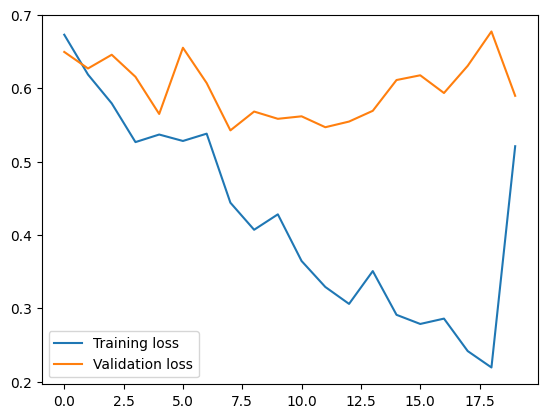

In [27]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

### (2 points) Add an accuracy function and report the accuracy of the training and test set.


In [28]:
def check_accuracy(data: np.ndarray, model: nn.Module):
    num_correct = 0
    num_samples = 0
    
    with torch.no_grad():
        for inputs, labels in data:
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)
            
            # prediction = 1 if the model outputs y > 0.5
            #            = 0 otherwise
            predictions = (torch.flatten((model(inputs)) > 0.5).int()).to(device)
            num_correct += (predictions == labels).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)}')

In [29]:
print("Train set accuracy on RNN:")
check_accuracy(train_gen(), model)
print("Test set accuracy on RNN:")
check_accuracy(test_gen(), model)

Train set accuracy on RNN:
Got 16746 / 20000 with accuracy 0.8373
Test set accuracy on RNN:
Got 19140 / 25000 with accuracy 0.7656


### (3 points) Create an LSTM class which uses an LSTM. Compare its results with the RNN.


In [30]:
class LSTM(nn.Module):
    """A simple LSTM module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs
        
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        
        self.lstm = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True
        )
        
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)
        
        c0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        out, _ = self.lstm(out, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)

        return out

In [31]:
lstm_model = LSTM(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(lstm_model.parameters())

In [32]:
train_losses, valid_losses, lstm_model = train(lstm_model, criterion, optimizer, 20, train_gen, valid_gen)

Epoch: 0, training loss: 0.654587032365799, validation loss: 0.6639783917718632, in 0:00:21.428943
Saving for valid loss = 0.6639783917718632
Epoch: 1, training loss: 0.5511450848102569, validation loss: 0.5479711404271946, in 0:00:21.199853
Saving for valid loss = 0.5479711404271946
Epoch: 2, training loss: 0.5154399610996246, validation loss: 0.5331867208146746, in 0:00:21.669444
Saving for valid loss = 0.5331867208146746
Epoch: 3, training loss: 0.4489753762722015, validation loss: 0.561011821980689, in 0:00:21.277473
Epoch: 4, training loss: 0.38647523691654206, validation loss: 0.41350220200742127, in 0:00:21.457732
Saving for valid loss = 0.41350220200742127
Epoch: 5, training loss: 0.3180704867959023, validation loss: 0.40510952880807743, in 0:00:21.415780
Saving for valid loss = 0.40510952880807743
Epoch: 6, training loss: 0.2637680352210999, validation loss: 0.3873153501635144, in 0:00:21.419977
Saving for valid loss = 0.3873153501635144
Epoch: 7, training loss: 0.228407415717

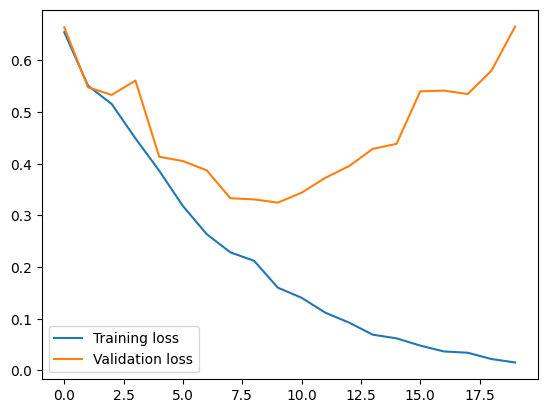

In [33]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

In [34]:
print("Train set accuracy on LSTM:")
check_accuracy(train_gen(), lstm_model)
print("Test set accuracy on LSTM:")
check_accuracy(test_gen(), lstm_model)

Train set accuracy on LSTM:
Got 19110 / 20000 with accuracy 0.9555
Test set accuracy on LSTM:
Got 21484 / 25000 with accuracy 0.85936


### (2 point) Implement a function which takes any text and return the model's prediction.
The function should have a string as input and return a class (0 or 1) and its probability (score out of a sigmoid).\
Don't forget to make the text go through the same pretreatment and encoding you used to train your model.


In [56]:
def model_predict(model: nn.Module, txt: str):
    output = model(torch.tensor(np.array([encode_text(pretreatment(txt))])).to(device))

    output_class = (output > 0).int()
    probability = nn.Sigmoid()(output) if output_class == 1 else 1 - nn.Sigmoid()(output)
    return output_class, probability

print(model_predict(lstm_model, "I adore this movie a lot"))
print(model_predict(lstm_model, "I hate this movie from every fiber of my being"))

(tensor([[1]], device='cuda:0', dtype=torch.int32), tensor([[0.7337]], device='cuda:0', grad_fn=<SigmoidBackward0>))
(tensor([[0]], device='cuda:0', dtype=torch.int32), tensor([[0.8013]], device='cuda:0', grad_fn=<RsubBackward1>))


### (3 points) Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
To combine the last output of both direction, you can concatenate, add, or max-pool them. Please document your choice.


In [36]:
class BiLSTM(nn.Module):
    """A simple LSTM module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs

        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        
        self.lstm = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            bidirectional = True,
            batch_first = True
        )
        self.fc = nn.Linear(self.hidden_size * 2, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers*2, X.size(0), self.hidden_size).to(device)
        
        c0 = torch.zeros(self.n_layers*2, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        out, _ = self.lstm(out, (h0, c0))
        
        out = out[:, -1, :]
        out = self.fc(out)

        return out

In [37]:
bilstm_model = BiLSTM(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(bilstm_model.parameters())

In [38]:
train_losses, valid_losses, bilstm_model = train(bilstm_model, criterion, optimizer, 20, train_gen, valid_gen)

Epoch: 0, training loss: 0.6457473314285278, validation loss: 0.5975296470769651, in 0:00:33.742868
Saving for valid loss = 0.5975296470769651
Epoch: 1, training loss: 0.5468830019950867, validation loss: 0.5052674711699698, in 0:00:34.243123
Saving for valid loss = 0.5052674711699698
Epoch: 2, training loss: 0.47893245463371276, validation loss: 0.6006452627242751, in 0:00:34.546629
Epoch: 3, training loss: 0.44506051831245425, validation loss: 0.4855203421632196, in 0:00:30.814230
Saving for valid loss = 0.4855203421632196
Epoch: 4, training loss: 0.4310098427772522, validation loss: 0.43597988214842076, in 0:00:33.232354
Saving for valid loss = 0.43597988214842076
Epoch: 5, training loss: 0.3480692392706871, validation loss: 0.4166596093375212, in 0:00:33.974102
Saving for valid loss = 0.4166596093375212
Epoch: 6, training loss: 0.29467835150957106, validation loss: 0.3651777465062536, in 0:00:31.745958
Saving for valid loss = 0.3651777465062536
Epoch: 7, training loss: 0.4213034362

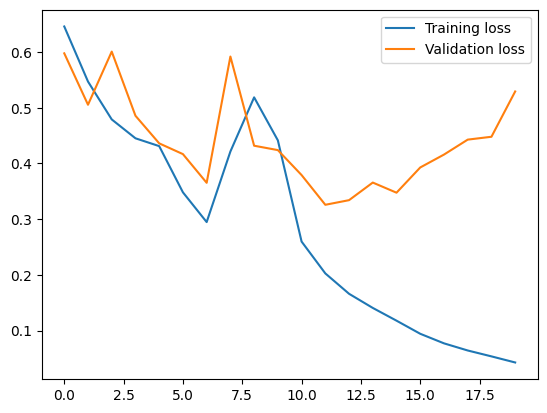

In [39]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

In [40]:
print("Train set accuracy on BiLSTM:")
check_accuracy(train_gen(), bilstm_model)
print("Test set accuracy on BiLSTM:")
check_accuracy(test_gen(), bilstm_model)

Train set accuracy on BiLSTM:
Got 18791 / 20000 with accuracy 0.93955
Test set accuracy on BiLSTM:
Got 21374 / 25000 with accuracy 0.85496


### (1 point) With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.


In [41]:
print("RNN accuracy : ")
check_accuracy(test_gen(), model)
print("LSTM accuracy : ")
check_accuracy(test_gen(), lstm_model)
print("BiLSTM accuracy : ")
check_accuracy(test_gen(), bilstm_model)

RNN accuracy : 
Got 19140 / 25000 with accuracy 0.7656
LSTM accuracy : 
Got 21484 / 25000 with accuracy 0.85936
BiLSTM accuracy : 
Got 21374 / 25000 with accuracy 0.85496


Le BiLSTM/LSTM semblent être les meilleurs modèles.

In [64]:
best_model = lstm_model

failed_sample1 = None
failed_sample2 = None

for text, label in zip(clean_dataset_split["test"]["text"], clean_dataset_split["test"]["label"]):
    prediction, _ = model_predict(best_model, text)
    
    if prediction[0][0] == 1 and label == 0:
        failed_sample1 = text
    if prediction[0][0] == 0 and label == 1:
        failed_sample2 = text
    
    if failed_sample1 is not None and failed_sample2 is not None:
        break

#### Ceci est un faux positif. Le lexique positif peut laisser penser que c'est un commentaire positif alors qu'il considère l'oeuvre ne peut être appréciée que par des enfants.

In [65]:
failed_sample1

'the first shiloh film was enjoyable by adults as well as children  this one starts with about an hour of filler where not much happens  with stilted dialogue  only in the last act is there any significant action that really moves the plot along  the dog is still cute  though  and young kids may enjoy it '

#### Ceci est un faux négatif. Il relève les défauts du film dans son commentaire mais conclu que le film est au dessus de la moyenne ("above average")

In [66]:
failed_sample2

'this is my first deepa mehta film  i saw the film on tv in its hindi version with its  sita  character presented as nita  i also note that it is radha who underwent the allegorical trial by fire in the film and not nita sita  yet what i loved about the film was its screenplay by ms mehta  not her direction  the characters  big and small  were well developed and seemed quixotic towards the end  somewhat like the end of mazursky s  an unmarried woman   they are brave women surrounded by cardboard men  and one cardboard man  ashok  seems to come alive in the last shot we see of him   carrying his invalid mother biji  he seems to finally take on a future responsibility beyond celibacy and adherance to religion   br    br   ms mehta seems to fumble as a director  however  compared to most indian mainstream cinema she would seem to be brilliant  as she cannot use her script to go beyond the microscopic joint family she is presenting except presenting a glimpse of the chinese micro minority 

### (Bonus) Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

## Theoritical questions (9 points)

### (2 points) Explain with your own words, using a short paragraph for each, what are:

- Phonetics and phonology

La phonétique est l'étude des propriétés physiques des sons de la parole, tandis que la phonologie est l'étude de la manière dont les sons sont utilisés dans les langues.

- Morphology and syntax

La morphologie et la syntaxe sont les deux principales branches de la grammaire. La morphologie est l'étude de la structure des mots, tandis que la syntaxe est l'étude de la structure des phrases.

- Semantics and pragmatics

La sémantique est l'étude de la signification des mots et des phrases dans une langue, tandis que la pragmatique est l'étude de l'utilisation de la langue dans la communication.

### (1 point) What is the difference between stemming and lemmatization?
- How do they both work?

Le stemming et la lemmatisation sont deux méthodes utilisées pour réduire les mots dérivés à leur forme de base. La principale différence entre ces deux méthodes est que la lemmatisation tient compte du contexte et convertit le mot en sa forme de base significative, alors que le stemming se contente de supprimer les derniers caractères, ce qui conduit souvent à des interprétations inexactes.

- What are the pros and cons of both methods?

La lemmatisation est une forme plus sophistiquée d'épellation qui peut produire des résultats plus précis. Cependant, elle peut également être plus coûteuse en termes de calcul, ce qui peut la rendre peu pratique. En outre, la lemmatisation peut parfois produire des résultats moins pertinents que ceux obtenus par le stemming.

### (1 point) On logistic regression:
- How does stochastic gradient descent work?

La descente de gradient stochastique fonctionne en faisant des petits pas itératifs dans la direction du gradient de la fonction objectif. 

- What is the role of the learning rate?

Le taux d'apprentissage est l'hyperparamètre qui permet de mettre à l'échelle le gradient pour mieux maîtriser la covergence vers le minimum.
- Will it always find the global minimum?

La régression logistique ne trouve pas toujours le minimum. Il est possible que l'algorithme reste bloqué dans un minimum local.

### (1 point) What problems does TF-iDF try to solve?

TF-iDF est utilisé pour déterminer la pertinance des mots en introduisant la fréquence des mots pour expliciter leur importance dans le document. 

- What the is the TF part for?

Le "TF" de TF-iDF signifie term frequency. Il s'agit du nombre de fois qu'un terme donné apparaît dans un document. 

- What is the iDF part for?

La partie iDF de TF-iDF correspond à inverse document frequency. Il s'agit d'une mesure de l'importance d'un mot dans un document. La fréquence inverse des documents est calculée en prenant le logarithme du nombre de documents divisé par le nombre de documents qui contiennent le mot.

### (2 point) Summarize how the skip-gram method of Word2Vec works using a couple of paragraphs.

Skip-gram est une méthode qui essaie de prédire un mot en fonction de son contexte. Le contexte est l'ensemble des mots qui entourent le mot cible. Le modèle de skip-gram essaie ensuite de prédire chaque mot du contexte en fonction d'un mot cible.


- How does it uses the fact that two words appearing in similar contexts are likely to have similar meanings?

Le modèle skip-gram utilise le fait que deux mots apparaissant dans des contextes similaires sont susceptibles d'avoir des significations semblables en supposant que les mots qui apparaissent dans des contextes similaires ont des significations équivalentes. Le modèle skip-gram utilise cette hypothèse pour apprendre des vecteurs de mots.

### (1 point) What are the differences between an RNN and an LSTM?

Un RNN est un réseau neuronal récurrent qui peut être utilisé pour modéliser des données séquentielles. Un LSTM est un réseau à mémoire à long terme, qui est un type de RNN conçu pour apprendre les dépendances à long terme.

- What problem is an LSTM trying to solve compared to a basic RNN?

Les LSTM sont conçus pour résoudre le problème du vanishing gradient, qui se produit lors de l'entraînement des RNN sur de longues séquences de données.

### (1 point) What would you expect if we use one of our classifiers trained on IMDB on Twitter data, and why?

On s'attend à ce que ça ne fonctionne pas correctement parce que le language utilisé sur Twitter diffère de celui utilisé par les utilisateur d'imdb. En outre, les messages sont en moyenne beaucoup plus courts. De manière générale, les données d'entraînement d'imdb sont très différentes de celles de Twitter.